In [1]:
import numpy as np
import pandas as pd

from pprint import pprint

lprint = lambda l: pprint(list(l))

In [2]:
from pathlib import Path

benchmarks = { path.stem: pd.read_csv(path) for path in Path('data/').glob('*/csv/*.csv') }

# Remove un-wanted dataframes
del benchmarks['cuda-mst-naive-K020-E1'] # Over-segmented
del benchmarks['cuda-mst-naive-K040-E1'] # Over-segmented
del benchmarks['gpu-baseline-S3']        # Broken segmentation
del benchmarks['rec-mst-S2']             # Over-segmented
del benchmarks['rec-mst-S3']             # Over-segmented
del benchmarks['cpu-baseline-K040']      # Over-segmented
del benchmarks['cpu-baseline-K640']      # Under-segmented

for name, df in benchmarks.items():
    # Parse algorithm name and parameters as a column in the dataframes
    if 'cuda-mst-naive' in name:
        df['algorithm'] = 'naive-mst-' + name.split('-')[-2]
    elif 'fill-black-control' in name:
        df['algorithm'] = 'control'
    elif 'baseline' in name:
        df['algorithm'] = name.split('-')[0] + '-' + name.split('-')[2]
    else:
        df['algorithm'] = name
    
    # Remove directories in output and ground_truth paths
    stemify = lambda p: Path(p).stem
    split1 = lambda p: stemify(p).split('_')[0]
    split2 = lambda p: stemify(p).split('_')[1]
    
    df['output'] = df['output'].apply(split1)
    df['ground_truth'] = df['ground_truth'].apply(split2)
    
    # Keep only the ground_truth that has the best ASA score for each output
    df = df[df.groupby(['output'])['asa_score'].transform(max) == df['asa_score']]
    
    benchmarks[name] = df
    
benchmarks = pd.concat(benchmarks.values())

In [3]:
# List benchmark names
lprint(benchmarks['algorithm'].unique())

['cpu-K080',
 'cpu-K160',
 'cpu-K320',
 'naive-mst-K080',
 'naive-mst-K160',
 'naive-mst-K320',
 'control',
 'gpu-S4',
 'gpu-S5',
 'gpu-S6',
 'rec-mst-S4',
 'rec-mst-S5',
 'rec-mst-S6']


In [4]:
print(benchmarks.groupby('algorithm')['asa_score'].mean())
print(benchmarks.groupby('algorithm')['ue_score'].mean())

algorithm
control           0.544975
cpu-K080          0.971168
cpu-K160          0.952400
cpu-K320          0.912502
gpu-S4            0.937752
gpu-S5            0.867792
gpu-S6            0.734224
naive-mst-K080    0.921781
naive-mst-K160    0.885564
naive-mst-K320    0.851115
rec-mst-S4        0.938258
rec-mst-S5        0.867081
rec-mst-S6        0.723534
Name: asa_score, dtype: float64
algorithm
control           0.796355
cpu-K080          0.057364
cpu-K160          0.094505
cpu-K320          0.171312
gpu-S4            0.123776
gpu-S5            0.259567
gpu-S6            0.504049
naive-mst-K080    0.155007
naive-mst-K160    0.225806
naive-mst-K320    0.291176
rec-mst-S4        0.122708
rec-mst-S5        0.260635
rec-mst-S6        0.521223
Name: ue_score, dtype: float64


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats; set_matplotlib_formats('svg')

<Figure size 432x288 with 0 Axes>

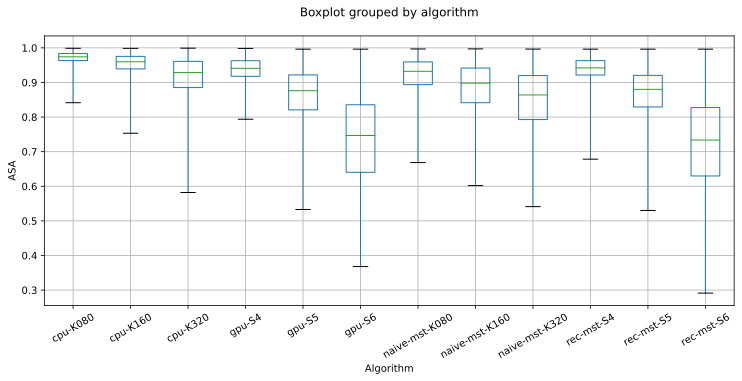

In [6]:
nocontrol = benchmarks[benchmarks['algorithm'] != 'control']

fig = plt.figure()

ax = nocontrol.boxplot(column='asa_score', by='algorithm', figsize=(12, 5), whis=float('inf'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('Algorithm')
ax.set_ylabel('ASA')
ax.set_title(None)

plt.show()

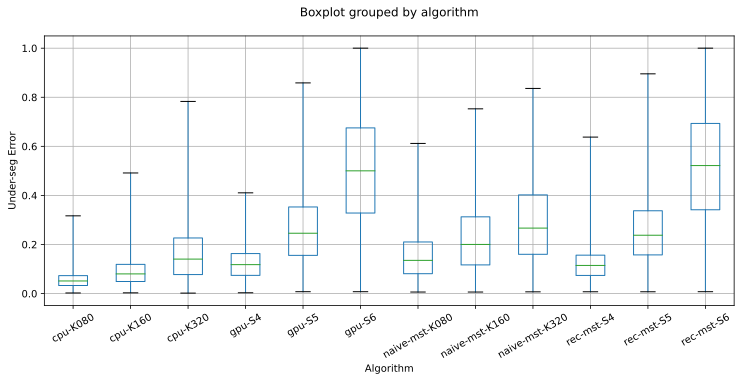

In [7]:
ax = nocontrol.boxplot(column='ue_score', by='algorithm', figsize=(12, 5), whis=float('inf'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xlabel('Algorithm')
ax.set_ylabel('Under-seg Error')
ax.set_title(None)

plt.show()

In [11]:
# Deepmind plot
cpu_k80 = benchmarks[benchmarks['algorithm'] == 'cpu-K080']
naive_k80 = benchmarks[benchmarks['algorithm'] == 'naive-mst-K080']
rec_mst_s4 = benchmarks[benchmarks['algorithm'] == 'rec-mst-S4']

cpu_k80_out = cpu_k80.sort_values('asa_score')['output'][::10]
asa_cpu = cpu_k80.set_index('output').loc[cpu_k80_out]['asa_score']
asa_naive = naive_k80.set_index('output').loc[cpu_k80_out]['asa_score']
asa_mst = rec_mst_s4.set_index('output').loc[cpu_k80_out]['asa_score']

<ipython-input-110-e841d80da157>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(cpu_k80_out), rotation=90)


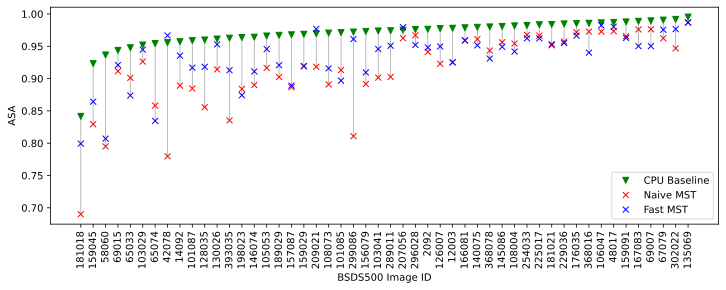

In [110]:
fig, ax = plt.subplots()
fig.set_size_inches((12, 4))


asa_min = pd.concat([asa_naive, asa_mst], axis=1).min(axis=1)
ax.vlines(cpu_k80_out, asa_min, asa_cpu, color='darkgrey', linewidth=0.8)
#ax.vlines(cpu_k80_out, asa_max, asa_cpu, color='C0', linewidth=0.3)


ax.plot(asa_cpu, 'v', color='green', label='CPU Baseline')
ax.plot(asa_naive, 'x', color='red', label='Naive MST')
ax.plot(asa_mst, 'x', color='blue', label='Fast MST')

ax.set_xticklabels(list(cpu_k80_out), rotation=90)

ax.legend()

ax.set_xlabel('BSDS500 Image ID')
ax.set_ylabel('ASA')

plt.show()

In [37]:
idx1

(array([ 0,  1,  2,  3,  5,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 19, 20,
        22, 23, 24, 25, 26, 28, 29, 31, 38, 42, 43, 47, 48], dtype=int64),)

In [39]:
idx2

(array([ 4,  6, 13, 18, 21, 27, 30, 32, 33, 34, 35, 36, 37, 39, 40, 41, 44,
        45, 46, 49], dtype=int64),)